## Loading

In [2]:
%load_ext autoreload
%autoreload 2

## Python version

In [3]:
# Python versions
import sys, site
print("Python:", sys.executable)
print("User site:", site.getusersitepackages())
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else "n/a")

Python: /home/nicolas/.pyenv/versions/venv_python_3.11.5-GCCcore-13.2.0/bin/python
User site: /home/nicolas/.local/lib/python3.11/site-packages
Site-packages: ['/home/nicolas/.pyenv/versions/venv_python_3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages']


## Librairies

In [4]:
# System and files
import os
import pickle
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass

# Files and data
import itertools
import collections
import numpy as np
import polars as pl
import fastparquet as fp
import pyarrow.parquet as pq
from dataclasses import fields

# Vizualization
from matplotlib import pyplot as plt
from tqdm import tqdm

# Personal package
from nucleo import plots as plts

## File Reading

In [12]:
def find_parquet_and_load(     
        base_folder = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs",
        **params
) -> pl.DataFrame:
    """
    Search for a parquet file in folder subfolders and check the specified values.
    Then load the parquet file as a Polars DataFrame.

    Args:
        root_directory (str): The root directory path to browse.
        **params: Keyword arguments representing the values to check in folder names.

    Returns:
        pl.DataFrame or None: Returns a Polars DataFrame if a matching file is found, otherwise None.
    """

    # List of subfolders in the root folder
    subdirs = [
        os.path.join(base_folder, d)
        for d in os.listdir(base_folder)
        if os.path.isdir(os.path.join(base_folder, d))
    ]

    # Main loop to iterate over subfolders
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):  # Browse subfolders
            for dirname in dirnames:
                folder_name = dirname

                # Check if all parameters match in the folder name
                if all(f"{key}_{value}__" in folder_name for key, value in params.items()):
                    # Path of the matching subfolder
                    subdir_path = os.path.join(dirpath, folder_name)
                    print(f"Corresponding subfile found: {subdir_path}")

                    # Look for .parquet files with 'data' in their name
                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet') and 'data' in filename:
                            pq_path = os.path.join(subdir_path, filename)
                            try:
                                # Load data using pyarrow and convert to Polars DataFrame
                                data = pq.read_table(pq_path)
                                df_polars = pl.DataFrame(data)
                                pl.Config.set_tbl_cols(len(df_polars.columns))
                                # Prints
                                # print('Values:', df_polars.columns)
                                # print(df_polars.head())
                                # print('Verification of data availability:', df_polars['times'].to_numpy())
                                print('File loaded and data availables')
                                return df_polars
                            except Exception as e:
                                print("Error loading parquet:", e)
                                return None

    # No matching folders found
    print("No sub-folders match the specified criteria.")
    return None


# Parameters
params = {
    "alpha_choice": "periodic",
    "s": 150,
    "l": 10,
    "bpmin": 0,
    "mu": 400,
    "theta": 50,
    "nt": 10_000,
    "tmax": 100,
    "dt": 1,
    "alphao": 0,
    "alphaf": 1,
    "beta": 0,
    "Lmin": 0,
    "Lmax": 50_000,
    "origin": 10_000,
    "bps": 1,
}

# Call
df_polars = find_parquet_and_load(**params)

Loading subfiles:  50%|█████     | 2/4 [00:00<00:00,  3.88 subfiles/s]

Corresponding subfile found: /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-01-01_PSMN/data_nucleo_nu_task_12/__alpha_choice_periodic__s_150__l_10__bpmin_0__mu_400__theta_50__nt_10000__tmax_100__dt_1__alphao_0__alphaf_1__beta_0__Lmin_0__Lmax_50000__origin_10000__bps_1__
File loaded and data availables


## Extracting Values

In [14]:
@dataclass(slots=True, kw_only=True, frozen=True)
class SimulationData:
    # Inputs
    alpha_choice: str; s: int; l: int; bpmin: int; 
    mu: float; theta: float
    nt: int; tmax: float; dt: float; times: np.ndarray
    alphao: float; alphaf: float; beta: float; 
    Lmin: int; Lmax: int; origin: int; bps: int

    # Obstacle
    alpha_mean: np.ndarray; obs_points: np.ndarray; obs_distrib: np.ndarray
    link_points: np.ndarray; link_distrib: np.ndarray; link_view: np.ndarray

    # Probabilities
    p: np.ndarray

    # Results
    results: np.ndarray; results_mean: np.ndarray; results_med: np.ndarray
    results_std: np.ndarray; v_mean: float; v_med: float

    # Fitting
    vf: float; vf_std: float; Cf: float; Cf_std: float; wf: float; wf_std: float

    # First pass times
    bin_fpt: int; fpt_distrib_2D: np.ndarray; fpt_number: np.ndarray

    # Time between jumps
    tbj_points: np.ndarray; tbj_distrib: np.ndarray

    # Instantaneous speeds
    dx_points: np.ndarray; dx_distrib: np.ndarray; dx_mean: float
    dx_med: float; dx_mp: float
    dt_points: np.ndarray; dt_distrib: np.ndarray; dt_mean: float
    dt_med: float; dt_mp: float
    vi_points: np.ndarray; vi_distrib: np.ndarray; vi_mean: float
    vi_med: float; vi_mp: float

    # Last parameters
    alpha_0: float

    # Plot tools
    xt_over_t: np.ndarray; G: np.ndarray; bound_low: float; bound_high: float

    @classmethod
    def from_polars(cls, df: pl.DataFrame):
        # Safety: we expect exactly one row
        if df.height == 0:
            raise ValueError("Empty DataFrame")
        if df.height > 1:
            df = df.head(1)

        # Grab the first row ONCE
        row = df.row(0, named=True)  # dict[str, Any]

        # Helper to turn list-like into np.ndarray (no copy if already ndarray)
        def to_np(x):
            return x if isinstance(x, np.ndarray) else np.asarray(x)

        # Columns that should become numpy arrays
        np_keys = {
            "times","alpha_mean","obs_points","obs_distrib",
            "link_points","link_distrib","link_view","p","results",
            "results_mean","results_med","results_std",
            "fpt_distrib_2D","fpt_number","tbj_points","tbj_distrib",
            "dx_points","dx_distrib","dt_points","dt_distrib",
            "vi_points","vi_distrib","xt_over_t","G"
        }

        # Convert only what’s needed
        converted = {k: (to_np(v) if k in np_keys else v) for k, v in row.items()}

        # Build the object (missing args will raise cleanly if schema drifts)
        return cls(**converted)


# Extracting
sim_data = SimulationData.from_polars(df_polars)
print("Values loaded")

Values loaded


## Illustrating

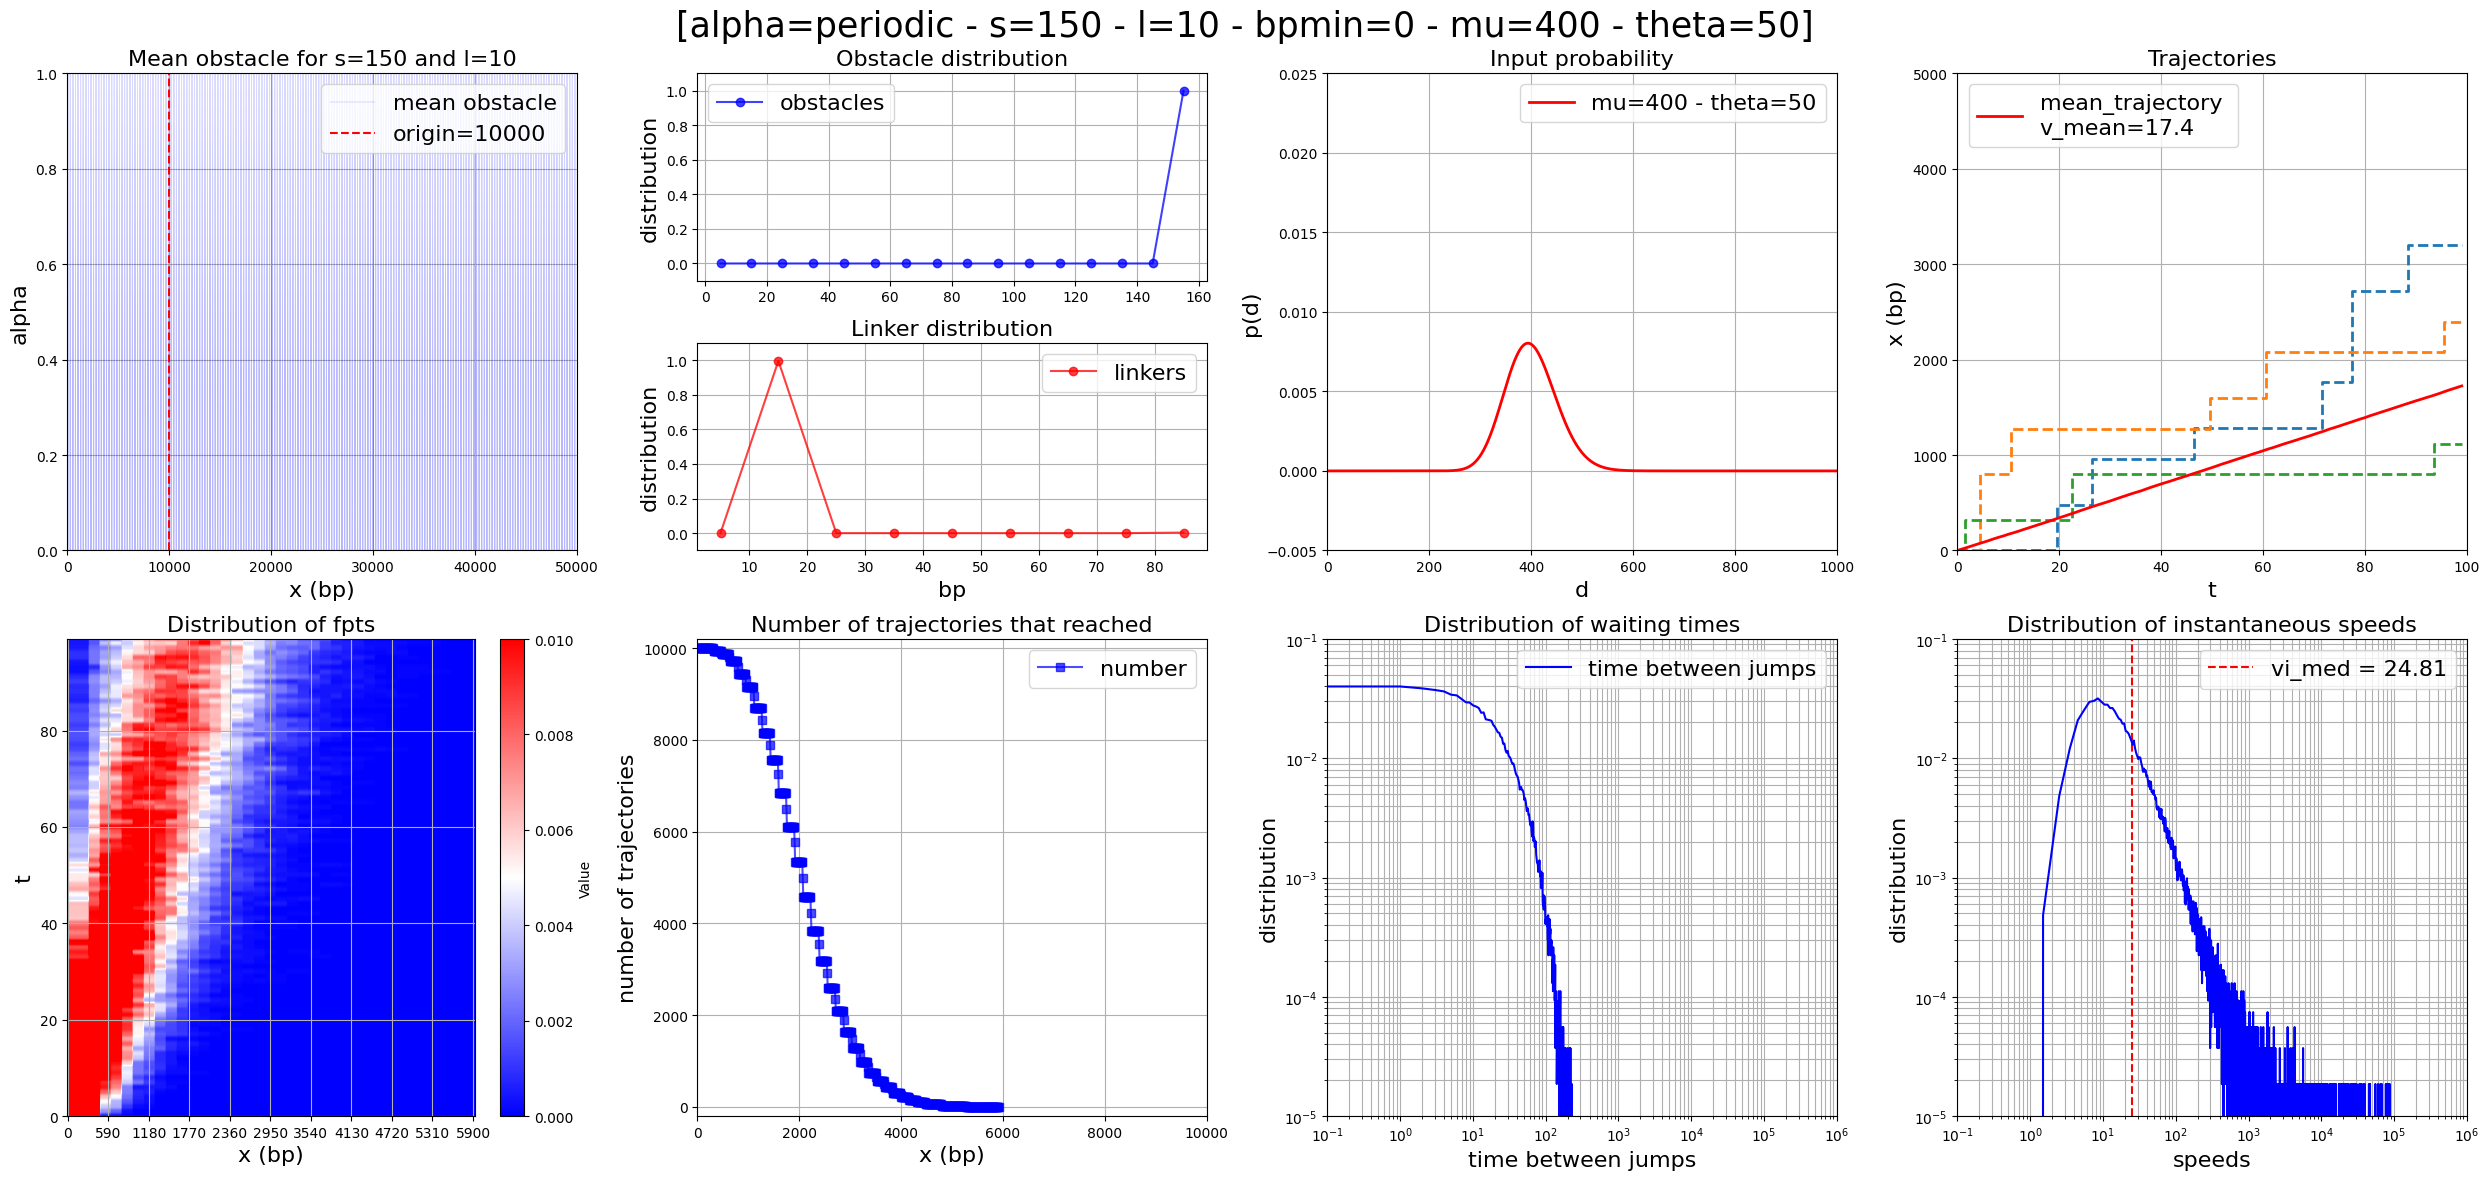

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
axes = axes.flatten()

plot_functions = [
    (plts.plot_obstacle, (sim_data.s, sim_data.l, sim_data.origin, sim_data.alpha_mean)),
    (plts.plot_obs_linker_distrib, (sim_data.obs_points, sim_data.obs_distrib, sim_data.link_points, sim_data.link_distrib)),
    (plts.plot_probabilities, (sim_data.mu, sim_data.theta, sim_data.p)),
    (plts.plot_trajectories, (sim_data.tmax, sim_data.times, sim_data.results, sim_data.results_mean, sim_data.results_med, sim_data.results_std, sim_data.v_mean, sim_data.v_med)),
    (plts.plot_fpt_distrib_2d, (sim_data.fpt_distrib_2D, sim_data.tmax, sim_data.bin_fpt)),
    (plts.plot_fpt_number, (sim_data.nt, sim_data.tmax, sim_data.fpt_number, sim_data.bin_fpt)),
    (plts.plot_waiting_times, (sim_data.tbj_points, sim_data.tbj_distrib)),
    (plts.plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp))
]

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.alpha_choice} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

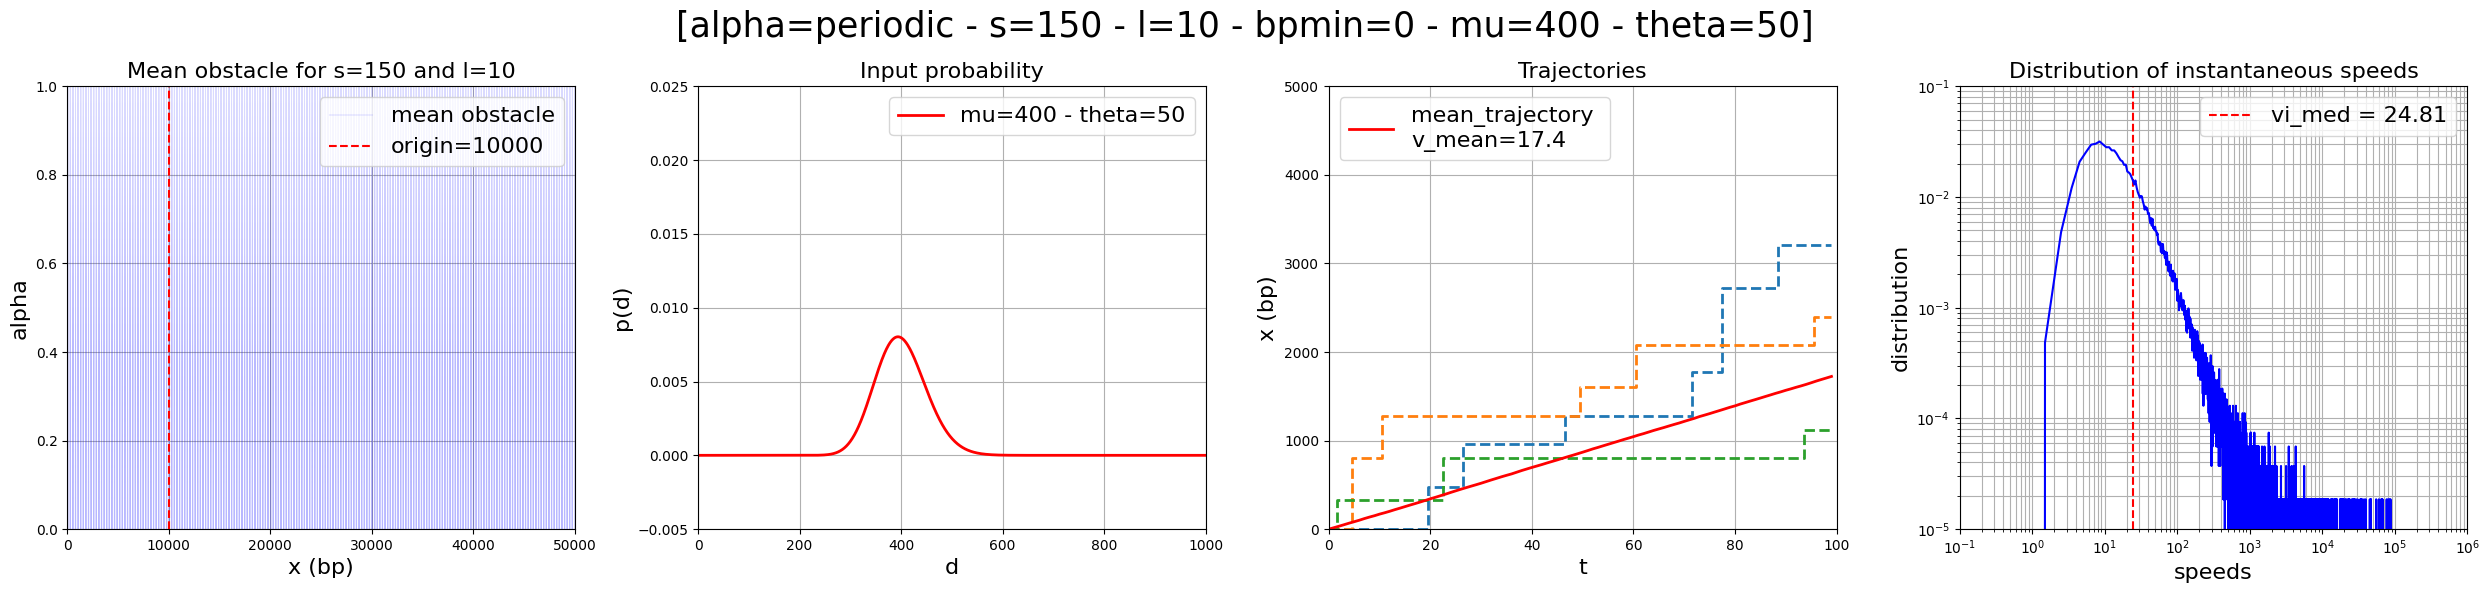

In [9]:
plot_functions = [
    (plts.plot_obstacle, (sim_data.s, sim_data.l, sim_data.origin, sim_data.alpha_mean)),
    (plts.plot_probabilities, (sim_data.mu, sim_data.theta, sim_data.p)),
    (plts.plot_trajectories, (sim_data.tmax, sim_data.times, sim_data.results, sim_data.results_mean, sim_data.results_med, sim_data.results_std, sim_data.v_mean, sim_data.v_med)),
    (plts.plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp))
]

fig, axes = plt.subplots(1, len(plot_functions), figsize=(25, 6))
axes = axes.flatten()

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.alpha_choice} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

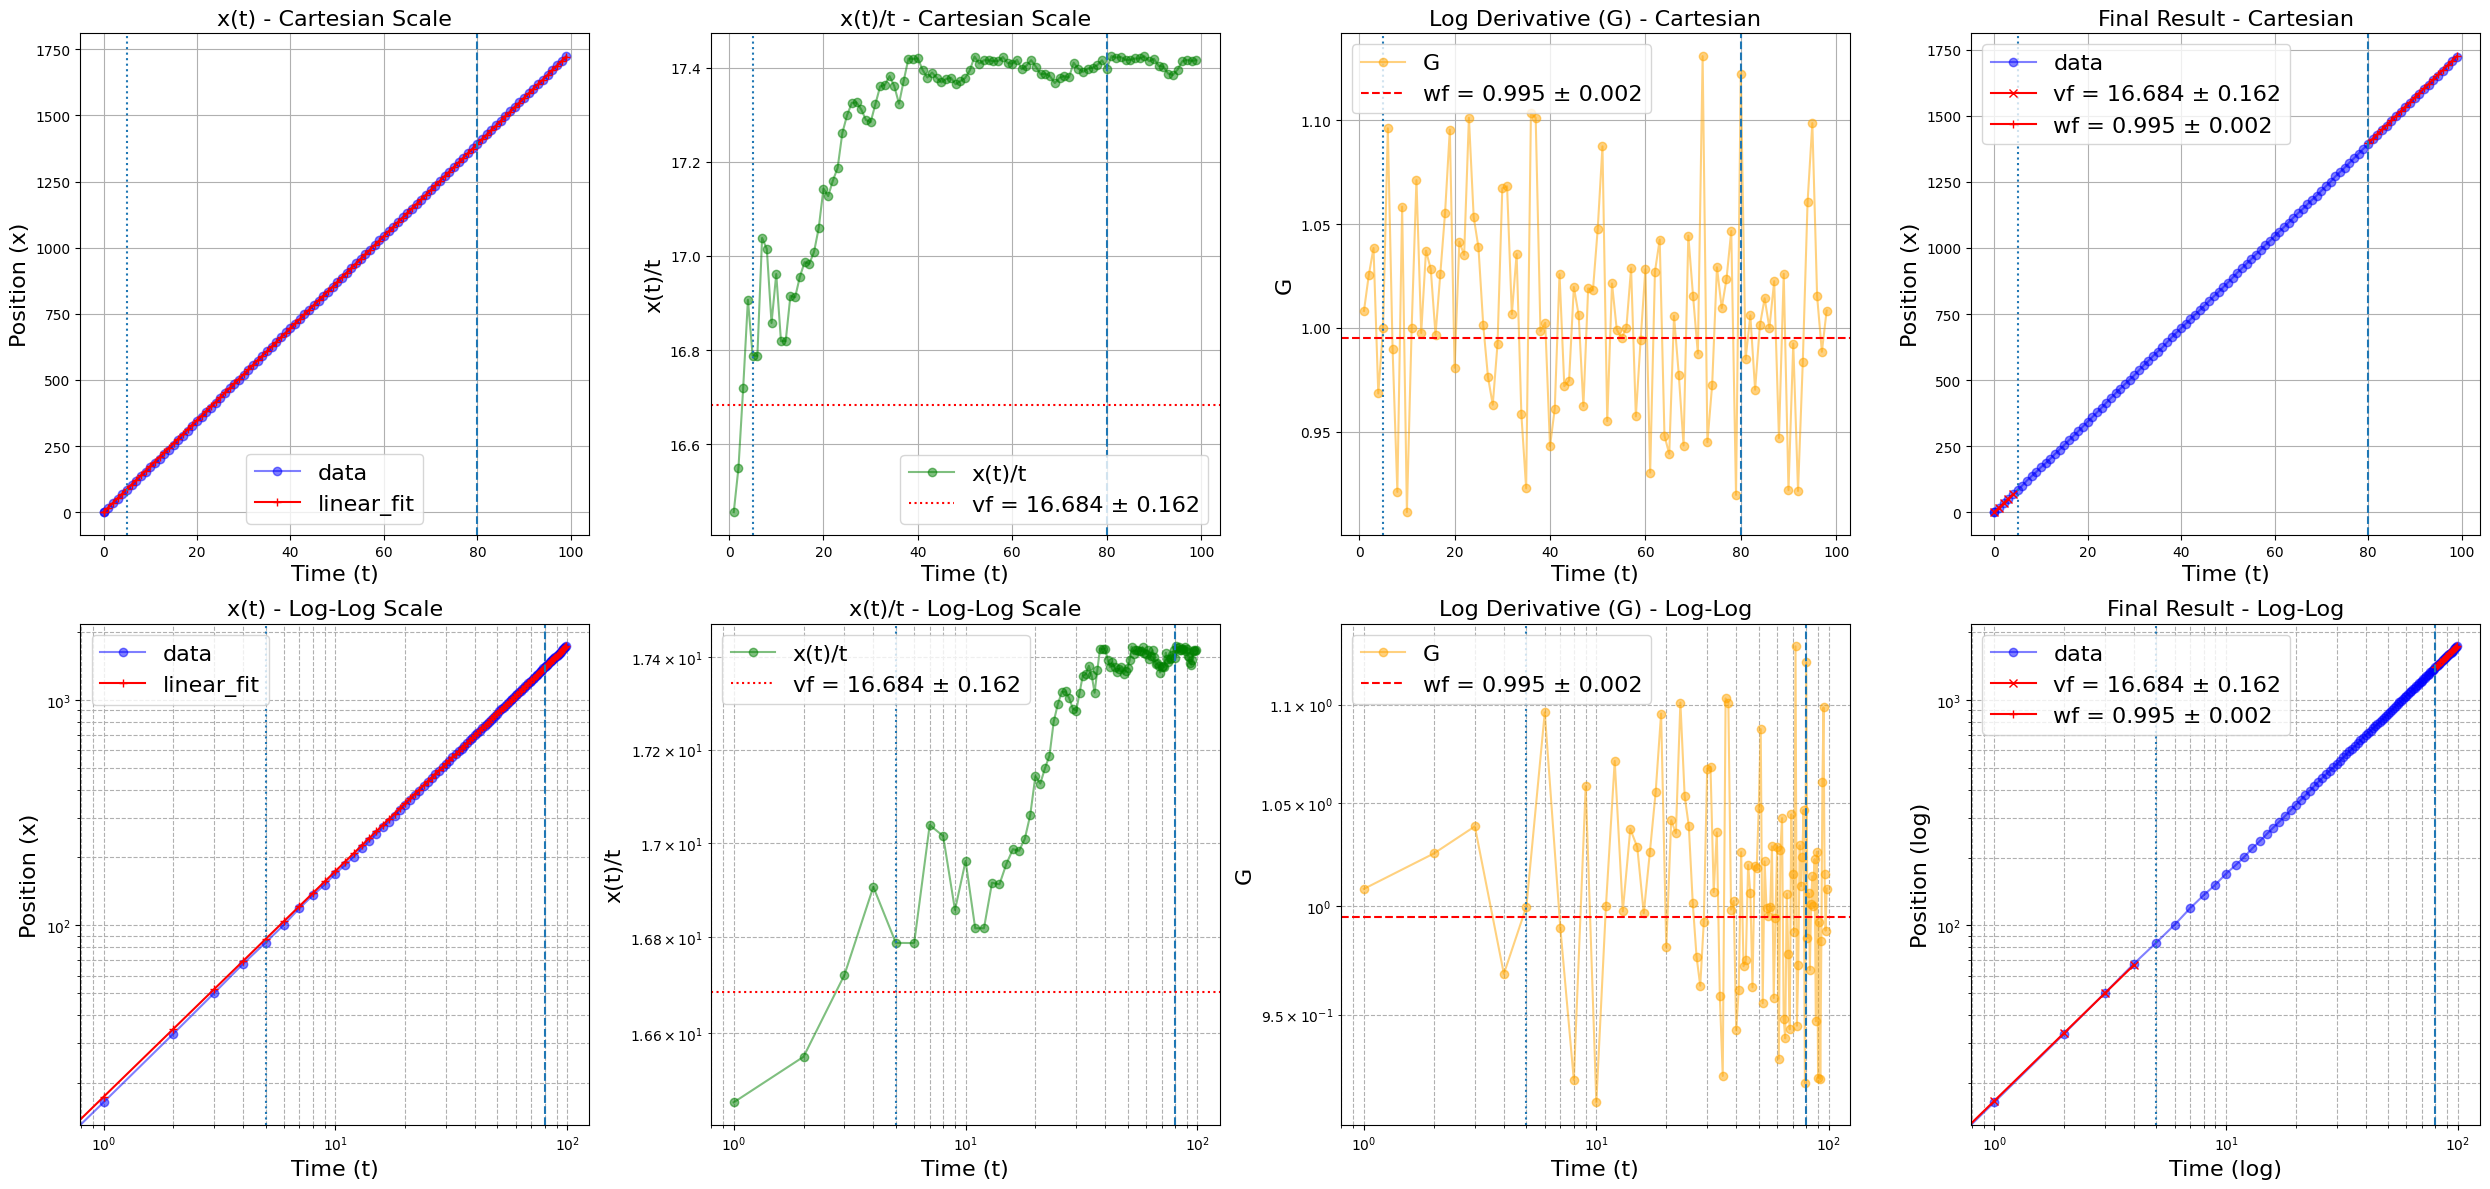

<Figure size 640x480 with 0 Axes>

In [10]:
plts.plot_fitting_summary(
    sim_data.times,
    sim_data.results_mean,
    sim_data.v_mean,
    sim_data.xt_over_t,
    sim_data.G,
    sim_data.vf,
    sim_data.vf_std,
    sim_data.Cf,
    sim_data.Cf_std,
    sim_data.wf,
    sim_data.wf_std,
    bound_low=sim_data.bound_low,
    bound_high=sim_data.bound_high,
    rf=3,
    text_size=16,
    ax=None
)

plt.tight_layout()
plt.show()

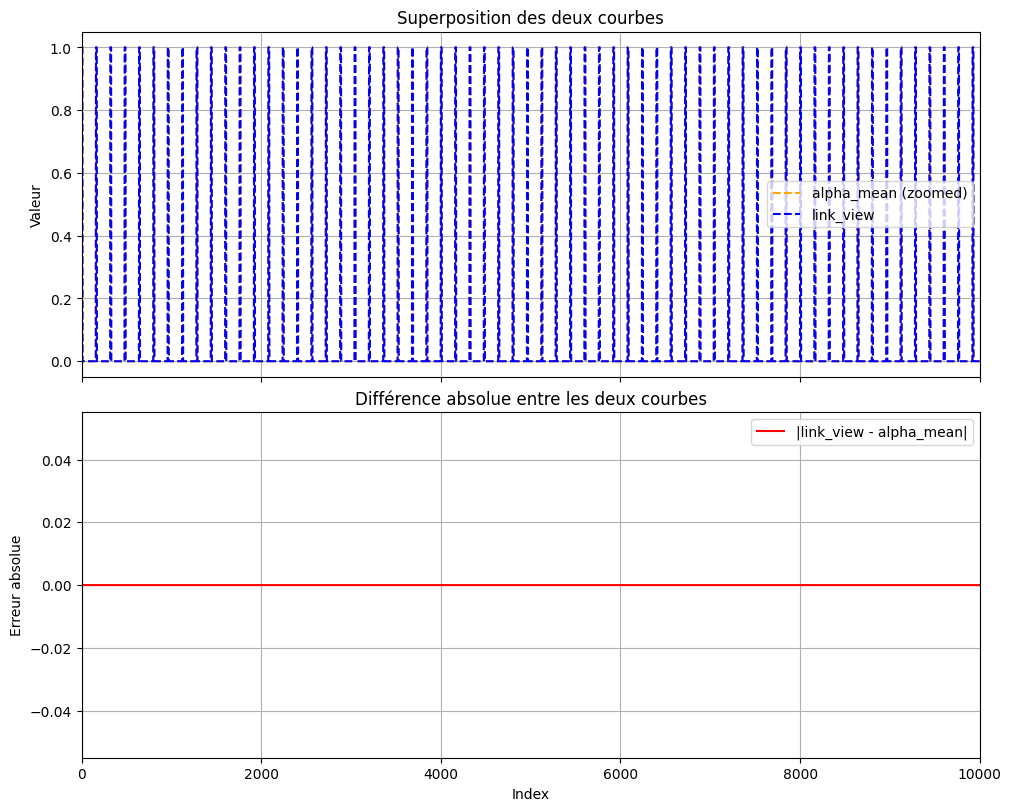

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True, constrained_layout=True)

# 1. Superposition des deux courbes
axes[0].plot(sim_data.alpha_mean[:len(sim_data.link_view)], label="alpha_mean (zoomed)", ls="--", color="orange")
axes[0].plot(sim_data.link_view, label="link_view", ls="--", color="blue")
axes[0].set_xlim(0, 10000)
axes[0].set_ylabel("Valeur")
axes[0].set_title("Superposition des deux courbes")
axes[0].legend()
axes[0].grid(True)

# 2. Différence absolue point à point
diff = np.abs(sim_data.link_view - sim_data.alpha_mean[:len(sim_data.link_view)])
axes[1].plot(diff, label="|link_view - alpha_mean|", color="red")
axes[1].set_xlim(0, 10000)
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Erreur absolue")
axes[1].set_title("Différence absolue entre les deux courbes")
axes[1].legend()
axes[1].grid(True)

plt.show()

# TESTS

In [ ]:
# Courbe de valeur maximale de (vi_med / mu) en fonction du point le plus chaud en suivant les configs en fait
# Donc c'est extraire le point maximal pour chaque config 
# Puis tracer ce point maximal en fonction de la config et donc de la taille du linker




In [44]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
plt.rcParams['font.size'] = 16


def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)

df_work = pl.DataFrame()
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])
# print(df_work)

all_peaks = []


plt.figure(figsize=(8,6))
for row in df_work.iter_rows(named=True):

    # Extracting datas
    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={row['l']}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    # Calculating sinusoid factors
    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    # Getting the local maximas
    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    # Plotting
    plt.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    plt.scatter(peaks, data[peaks], color="red", marker="x")

    
plt.xlim([0, 3000])
plt.ylim([0, 10])
plt.xlabel("position in bp")
plt.ylabel("phase count")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
for i in range(0, len(all_peaks)):
    plt.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
plt.xlabel("peak count")
plt.ylabel("peak position")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/ncl_test_0'

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import polars as pl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Définir le modèle sinusoidal
def sinusoid(t, A, omega, phi):
    return A * np.sin(omega * t + phi)

# Chargement des données
working_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "ncl_test_0"
os.chdir(working_path)
df_work = pl.concat([pl.read_parquet(file) for file in working_path.rglob("*.parquet") if file.is_file()])

all_peaks = []

# Création de la figure principale
fig, ax = plt.subplots(figsize=(8,6))  # 🔧 Figure + Axes

for row in df_work.iter_rows(named=True):

    l = row["l"]
    s = row["s"]
    alphaf = row["alphaf"]
    alphao = row["alphao"]
    link_view = row["link_view"]
    label = f"l={l}"
    norm = (s * alphao + alphaf * l) / (s + l)
    data = np.divide(link_view, norm)

    x = np.arange(0, len(data), 1)
    popt, _ = curve_fit(sinusoid, x, data)
    A_fit, omega_fit, phi_fit = popt

    peaks, _ = find_peaks(data, distance=100)
    all_peaks.append(peaks)
    
    ax.plot(data, label=f"{label} : y = {A_fit:.2f} sin({omega_fit:.2f} x + {phi_fit:.2f})")
    # ax.scatter(peaks, data[peaks], color="red", marker="x")

# Légendes principales
ax.set_xlim([0, 3000])
ax.set_ylim([0, 10])
ax.set_xlabel("position in bp")
ax.set_ylabel("phase count")
ax.legend(loc="upper left", fontsize=8)

# 🔍 Inset plot : zoom sur un pic
ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper right", borderpad=2)

# Exemple : zoomer sur la première courbe si elle existe
if len(all_peaks) > 0:
    for i in range(0, len(all_peaks)):
        ax_inset.plot(np.arange(0,10), all_peaks[i][0:10], label=f"{i}", marker="o")
        ax_inset.set_xlabel("peak count")
        ax_inset.set_ylabel("peak position")
        # ax_inset.set_xticks([])
        # ax_inset.set_yticks([])
        ax_inset.legend(fontsize=8)

# plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/ncl_test_0'

Working on: {'s': 150, 'l': 10, 'bpmin': 0, 'alpha_choice': 'nt_random'} 
With: output=vi_med - fx_name=theta - fx_value=50
shape: (1, 27)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ alp ┆ s   ┆ l   ┆ bpm ┆ mu  ┆ the ┆ nt  ┆ tma ┆ dt  ┆ alp ┆ alp ┆ bet ┆ Lmi ┆ Lma ┆ ori ┆ bps ┆ v_m ┆ v_m ┆ vf  ┆ Cf  ┆ wf  ┆ vf_ ┆ Cf_ ┆ wf_ ┆ vi_ ┆ vi_ ┆ vi_ │
│ ha_ ┆ --- ┆ --- ┆ in  ┆ --- ┆ ta  ┆ --- ┆ x   ┆ --- ┆ hao ┆ haf ┆ a   ┆ n   ┆ x   ┆ gin ┆ --- ┆ ean ┆ ed  ┆ --- ┆ --- ┆ --- ┆ std ┆ std ┆ std ┆ mea ┆ med ┆ mp  │
│ cho ┆ i64 ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ i64 ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ i64 ┆ --- ┆ --- ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ --- ┆ --- ┆ n   ┆ --- ┆ --- │
│ ice ┆     ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆     ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 ┆     ┆ f64 ┆ f64 ┆     ┆     ┆     ┆ f64 ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64 │
│ --- ┆     ┆     ┆     ┆     ┆     ┆    

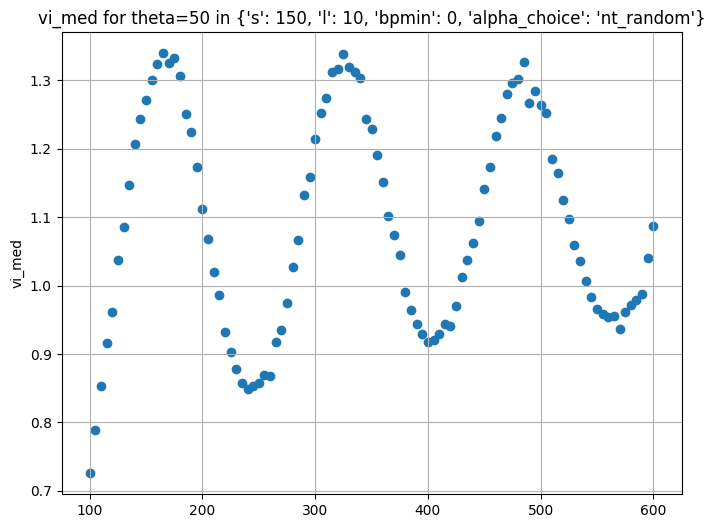

In [57]:
def ncl_cut_1D(df: pl.DataFrame, config: dict, output: str, fx_name: str, fx_value: float, norm_type=None, plot_log2=False) -> tuple[list, list]:
    

    # Proper call of function
    if output not in ["v_mean", "vi_med", "vi_mp", "vf", "wf"]:
        raise ValueError(f"Invalid speed_col: '{output}'")
    if fx_name not in ["mu", "theta"]:
        raise ValueError(f"Invalid fixed_input: '{fx_name}'")
    if norm_type not in ["raw", "norm_mu", "norm_th"]:
        raise ValueError(f"Invalid norm_type: '{norm_type}'")

    # Filtering data corresponding to configuration
    filters = (
        (pl.col("s") == config["s"]) &
        (pl.col("l") == config["l"]) &
        (pl.col("bpmin") == config["bpmin"]) &
        (pl.col("alpha_choice") == config["alpha_choice"])
    )

    # Fixed and non-fixed parameters
    if fx_name == "theta":
        mv_name = "mu"
    else: 
        mv_name = "theta"

    # Getting datas
    df_filtered = df.filter(filters & (pl.col(fx_name) == fx_value))
    x_values = df_filtered[mv_name].to_numpy()
    y_values = df_filtered[output].to_numpy()
    mu_values = df_filtered["mu"].to_numpy()

    # Test
    mu_min = 100
    mu_max = 250
    df_test = df.filter(filters & (pl.col("mu") > mu_min) & (pl.col("mu") < mu_max))
    row_vi_med_max = df_test.filter(pl.col("vi_med") == pl.max("vi_med")) # Max de vi_med pas de vi_med sur mu
    idx_max = row_vi_med_max["mu"].to_numpy()
    print(row_vi_med_max)
    print(idx_max)
    
    # Du coup, le fix parameters ou du moins sa valeur est issue de idx_max : on selectionne la colonne de la heatmap mu = 160
    # On extraie les valeurs telles que mu = 160 pour tous les theta
    # Et ensuite, on conserve ce max, que l'on plot pour chaque configuration aléatoire de (s,l) et on  a notre graph pour observer si rescue ou pas

    # Normalizations
    if norm_type:
        if norm_type == "norm_mu":
            norm = mu_values
        if norm_type == "norm_th":
            alpha_o = df_filtered['alphao'][0]
            alpha_f = df_filtered['alphaf'][0]
            s = df_filtered['s'][0]
            l = df_filtered['l'][0]
            norm = (alpha_o * s + alpha_f * l) / (s + l) * mu_values

    # Normalizing or not
    if output in {'v_mean', 'vi_med', 'vi_mp', 'vf'}:
        y_values = np.array(y_values) / norm
    elif output in {'Cf', 'wf'}:
        pass

    # Getting datas in log2 or not
    if plot_log2:
        y_values = np.log2(np.clip(y_values, 1e-10, None))
    else : 
        y_values = np.array(y_values)

    # Done
    return x_values, y_values

# Parameters
cfg = work_configs[3]
output = "vi_med"
fx_name = "theta"
fx_value = 50
print(f"Working on: {cfg} \nWith: output={output} - fx_name={fx_name} - fx_value={fx_value}")

# Call
x_plot, y_plot = ncl_cut_1D(df=work_df, config=cfg, output=output, fx_name=fx_name, fx_value=fx_value, norm_type="norm_th", plot_log2=False)

# Plot
plt.figure(figsize=(8,6))
plt.title(f"{output} for {fx_name}={fx_value} in {cfg}")
plt.scatter(x_plot, y_plot,marker="o")
plt.ylabel(f"{output}")
plt.grid(True)
plt.show()

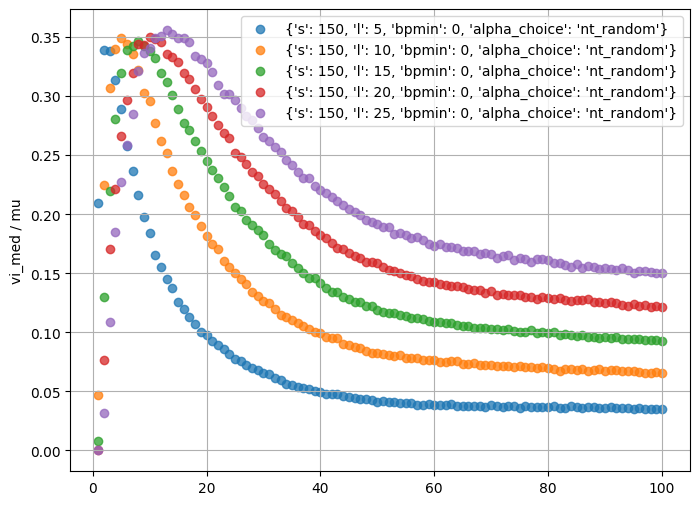

In [48]:
# Attention perte de periodicité au fur et à mesure
# Necessite une detection automatique du point le plus chaud : récupérer son mu_value

output = "vi_med"
fx_name = "mu"
norm_type = "norm_mu"

cfg_2 = work_configs[2]
s2, l2 = 150, 5
fx_value_2 = s2 + l2
x_plot_2, y_plot_2 = ncl_cut_1D(df=work_df, config=cfg_2, output=output, fx_name=fx_name, fx_value=fx_value_2, norm_type=norm_type, plot_log2=False)

cfg_3 = work_configs[3]
s3, l3 = 150, 10
fx_value_3 = s3 + l3
x_plot_3, y_plot_3 = ncl_cut_1D(df=work_df, config=cfg_3, output=output, fx_name=fx_name, fx_value=fx_value_3, norm_type=norm_type, plot_log2=False)

cfg_4 = work_configs[4]
s4, l4 = 150, 15
fx_value_4 = s4 + l4
x_plot_4, y_plot_4 = ncl_cut_1D(df=work_df, config=cfg_4, output=output, fx_name=fx_name, fx_value=fx_value_4, norm_type=norm_type, plot_log2=False)

cfg_5 = work_configs[5]
s5, l5 = 150, 20
fx_value_5 = s5 + l5
x_plot_5, y_plot_5 = ncl_cut_1D(df=work_df, config=cfg_5, output=output, fx_name=fx_name, fx_value=fx_value_5, norm_type=norm_type, plot_log2=False)

cfg_6 = work_configs[6]
s6, l6 = 150, 25
fx_value_6 = s6 + l6
x_plot_6, y_plot_6 = ncl_cut_1D(df=work_df, config=cfg_6, output=output, fx_name=fx_name, fx_value=fx_value_6, norm_type=norm_type, plot_log2=False)

plt.figure(figsize=(8,6))
plt.scatter(x_plot_2, y_plot_2, label=f"{cfg_2}", alpha=0.75)
plt.scatter(x_plot_3, y_plot_3, label=f"{cfg_3}", alpha=0.75)
plt.scatter(x_plot_4, y_plot_4, label=f"{cfg_4}", alpha=0.75)
plt.scatter(x_plot_5, y_plot_5, label=f"{cfg_5}", alpha=0.75)
plt.scatter(x_plot_6, y_plot_6, label=f"{cfg_6}", alpha=0.75)
plt.ylabel("vi_med / mu")
plt.grid(True)
plt.legend()
plt.show()


# III.1 A reprendre

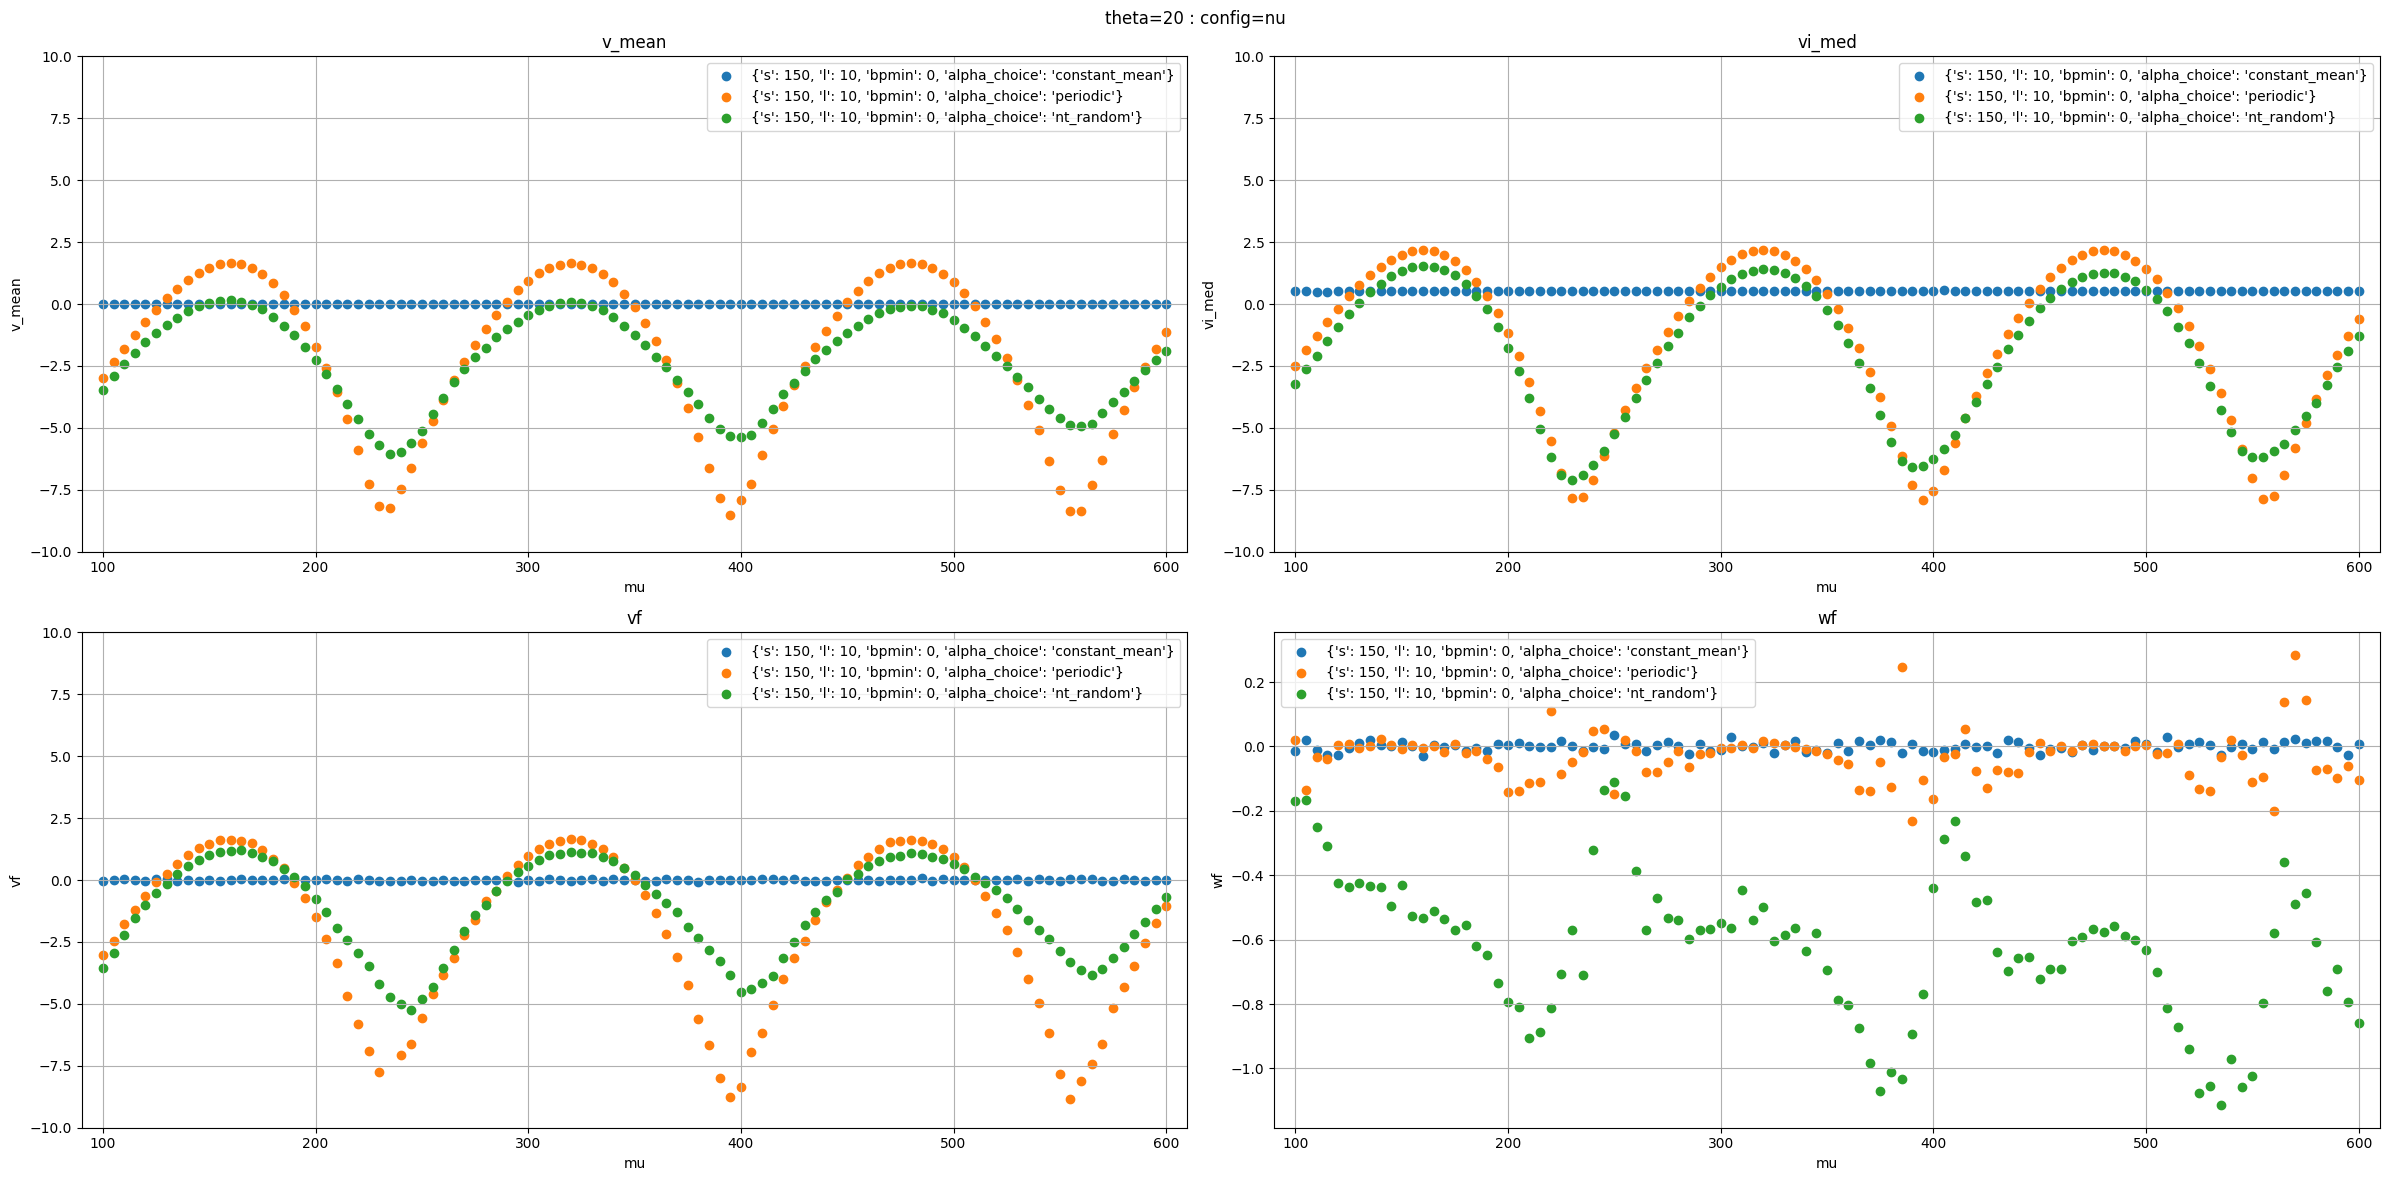

In [66]:
def ncl_multiplot_1D(param: str, param_value: int, config_choice: str):
    """
    Generate a 2x2 multiplot showing different speed-related metrics 
    as a function of the non-fixed parameter, for several configuration sets.

    Args:
        param (str): The name of the fixed parameter. Must be either `'mu'` or `'theta'`.
            This parameter is held constant at `param_value`.
        param_value (int): The fixed value for the `param` parameter.
        config_choice (str): The type of configuration group to use. Must be one of:
            - `'nu'`: selects configurations [0], [1], and [3] from `sorted_combinations_configs`
            - `'ls'`: selects configurations [3:10] plus [2]
            - `'bp'`: selects configurations from index 10 onward

    Raises:
        ValueError: If `param` is not `'mu'` or `'theta'`.
        ValueError: If `config_choice` is not one of `'nu'`, `'ls'`, or `'bp'`.

    Notes:
        - Four metrics are plotted: `"v_mean"`, `"vi_med"`, `"vf"`, and `"wf"`.
        - The x-axis corresponds to the non-fixed parameter (i.e., the one that is not `param`).
        - Each subplot represents one metric, with multiple configurations plotted in each.
        - The `data_1D` function is called to retrieve the (x, y) data for plotting.
        - A global legend and title are added for clarity.

    Example:
        >>> multiplot_1D(param="theta", param_value=25, config_choice="bp")
    """

    # Values to display
    values = ["v_mean", "vi_med", "vf", "wf"]
    n_values = len(values)


    # Fixed parameters
    settings = ["mu", "theta"]
    if param not in settings:
        print('No such param accessible : either mu or theta fixed')
        return None
    if (param == 'mu' and param_value not in np.arange(100,605,5)) or (param == 'theta' and param_value not in np.arange(1, 101, 1)):
        print('Not an accessible value for the parameter : either too low - two high - not binned')
        return None
    nfo = [x for x in settings if x != param][0]

    # Choice of configuration
    if config_choice not in ['nu', 'ls', 'bp']:
        raise ValueError('No such configuration')
    elif config_choice == 'nu':
        config = sorted_combinations_configs[0:2]
        config.append(sorted_combinations_configs[3])
    elif config_choice == 'ls':
        config = sorted_combinations_configs[3:10]
        config.append(sorted_combinations_configs[2])
    elif config_choice == 'bp':
        config = sorted_combinations_configs[10::]


    # Plot initialization
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

    # Loop over each value and config
    for ax, output in zip(axes.flatten(), values):
        for cfg in config:
            mu, v = ncl_data_1D(df=df_pl_main, config=cfg, speed_col=output, fixed_input=param, fixed_value=param_value)
            ax.scatter(mu, v, label=str(cfg), linewidth=1)

        ax.set_title(output)
        ax.set_xlabel(str(nfo))
        ax.set_ylabel(output)
        ax.grid(True, which='both')

        if param == 'theta':
            ax.set_xlim([90,610])
        elif param =='mu':
            ax.set_xlim([-10,110])

        if output in ["v_mean", "vi_med", "vf"]:
            ax.set_ylim([-10, 10])
        ax.legend()


    fig.suptitle(f"{param}={param_value} : config={configuration}")
    plt.tight_layout()
    plt.show()


# Calling function
parameter = 'theta'
parameter_value = 20
configuration = 'nu'
ncl_multiplot_1D(param=parameter, param_value=parameter_value, config_choice=configuration)
# You can call with "config_choice=sorted_combinations_configs" if you want all the results displayed at once

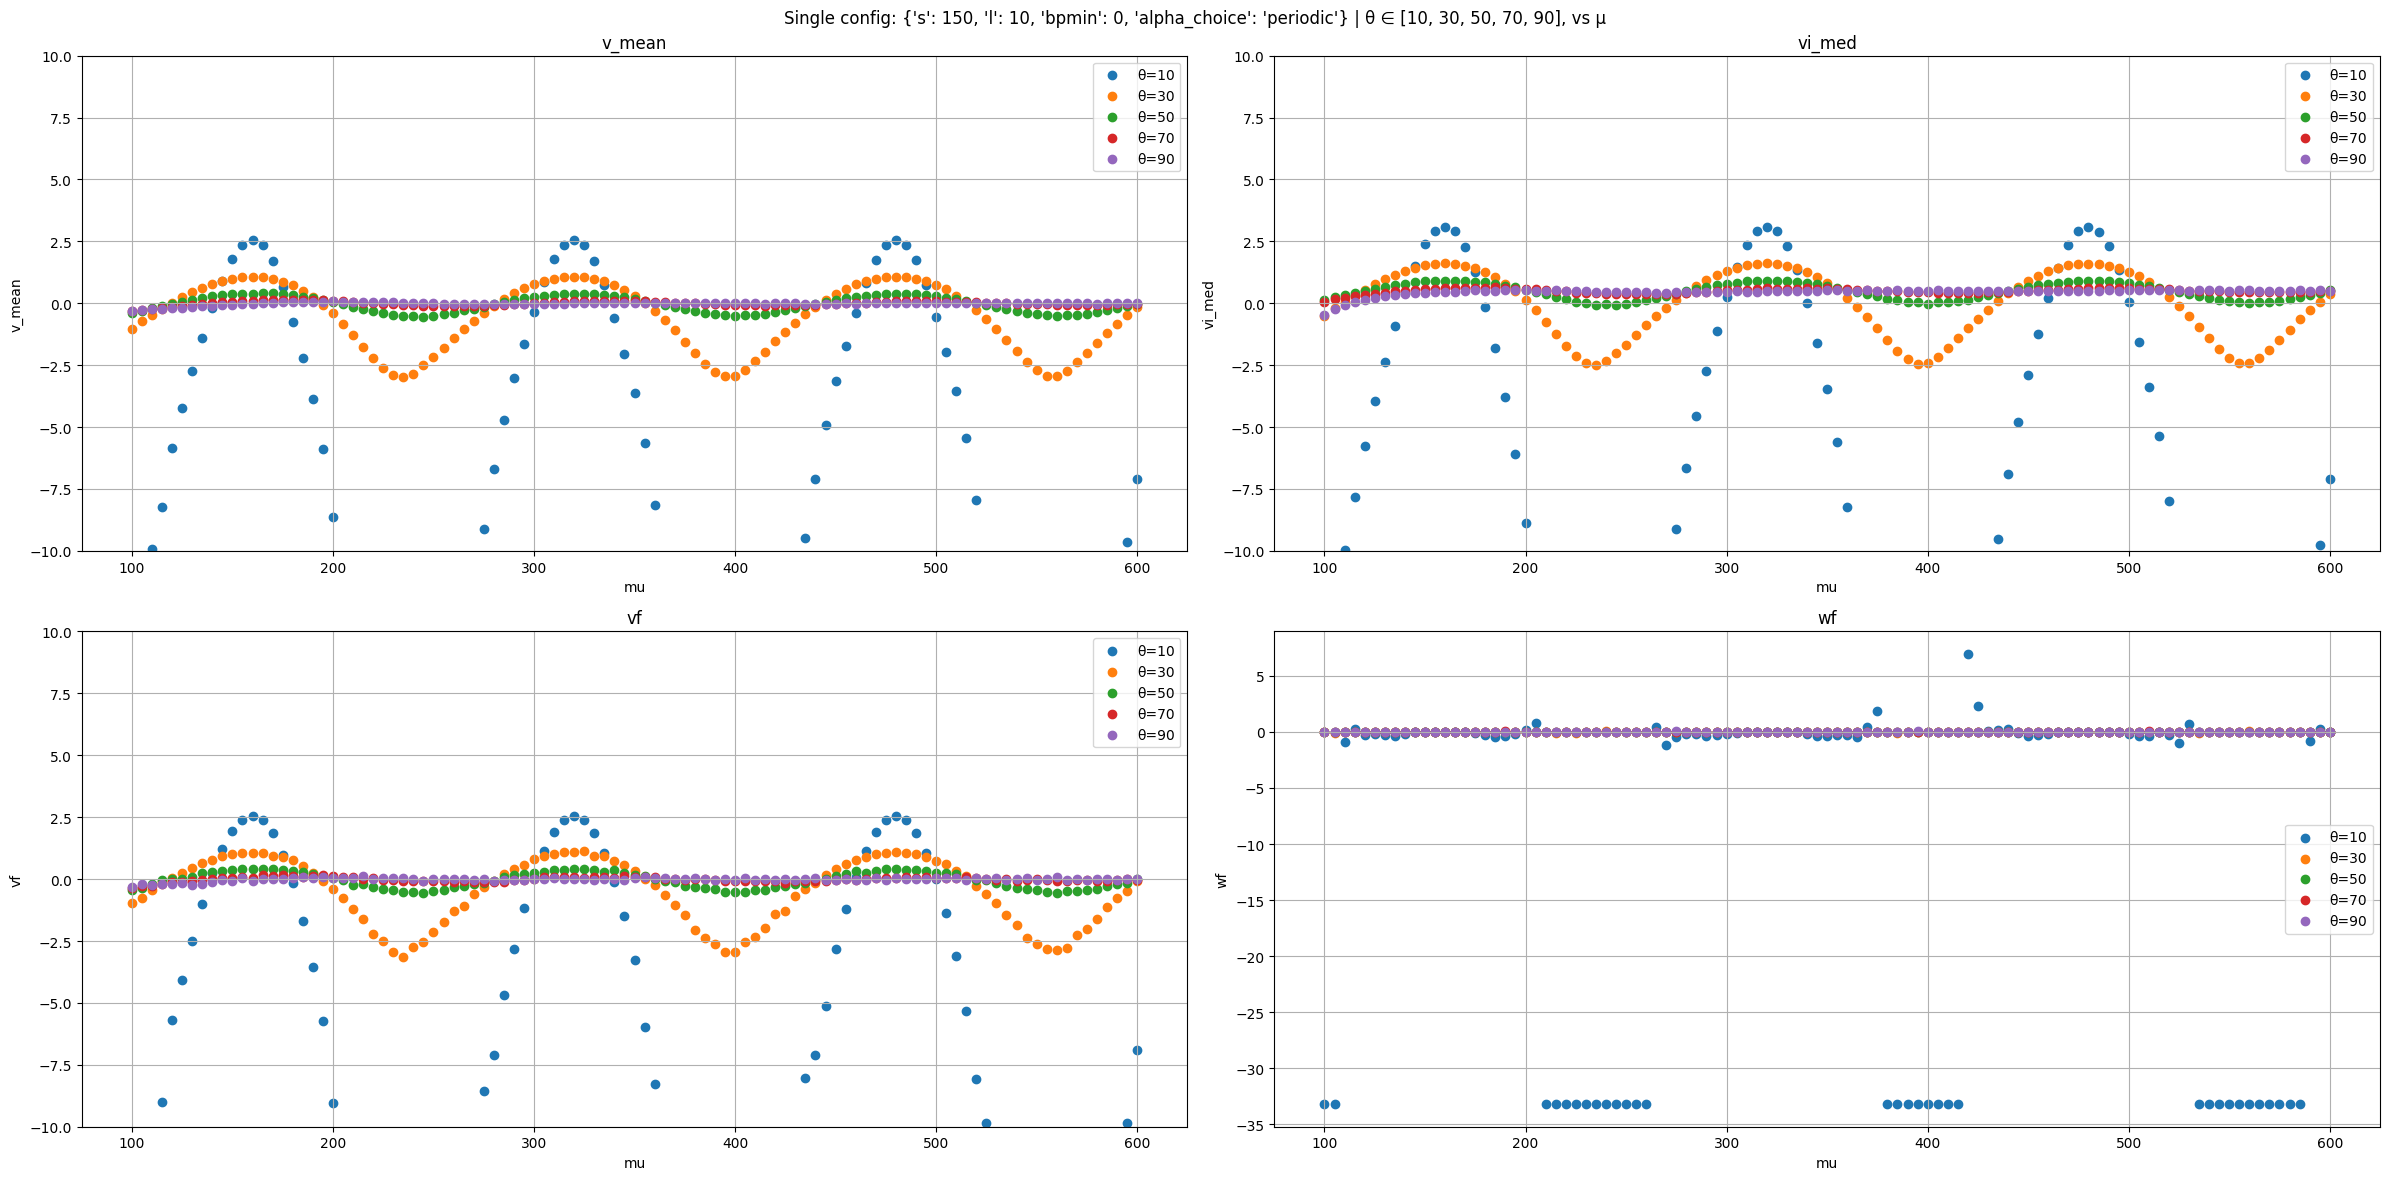

In [65]:
def ncl_multiplot_one_config_few_theta(config: list, theta_values: list = [10, 30, 50, 70, 90]):
    """
    Generate a 2x2 multiplot showing different speed-related metrics as a function of mu,
    for several fixed theta values, using a single configuration.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    metrics = ["v_mean", "vi_med", "vf", "wf"]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

    for ax, metric in zip(axes.flatten(), metrics):
        for theta in theta_values:
            try:
                # This call retrieves all mu for a fixed theta
                mu_vals, y_vals = ncl_data_1D(
                    df=df_pl_main,
                    config=config,
                    speed_col=metric,
                    fixed_input="theta",
                    fixed_value=theta
                )
                if len(mu_vals) == 0 or len(y_vals) == 0:
                    continue
                ax.scatter(x=mu_vals, y=y_vals, label=f"θ={theta}", marker='o')

            except Exception as e:
                print(f"Error at θ={theta} for {metric}: {e}")
                continue
        ax.set_title(metric)
        ax.set_xlabel("mu")
        ax.set_ylabel(metric)
        ax.grid(True, which='both')
        if metric in ["v_mean", "vi_med", "vf"]:
            ax.set_ylim([-10, 10])
        ax.legend()

    fig.suptitle(f"Single config: {config} | θ ∈ {theta_values}, vs μ")
    plt.tight_layout()
    plt.show()



config = sorted_combinations_configs[1]
ncl_multiplot_one_config_few_theta(config=config)


# .